In [117]:
#Automatic settings, constants
#In an effort to make this easier to use, the most important / commonly used constants and configurations
#can be found here. Change the values, then go and run all

#Location to load data from (.txt file, make sure there is no text besides the first four rows)
file_path = 'DD_DATA\log_18.txt'

#List of all properties collected in the log, IN ORDER
properties = [
"status", 
"rpm", 
"act_vel", 
"enc_pos", 
"in_trig", 
"out_trig", 
"s_time", 
"f_time", 
"o_vol", 
"o_curr",
"couple",
"therm1",
"therm2",
"therm3",
"estop",
"wheel_count",
"wheel_rpm",
]

#List of Properties that may be normalized & graphed by the multi auto graphs 
properties_to_normalize = ["rpm", "act_vel", "enc_pos", "o_vol", "o_curr", "couple", "therm1", "therm2", "therm3"]

#All of the tuples in this array will be graphed automatically
#In format (x, y), where x and y are strings found in properties
#Only for simple graphs where 2 properties are graphed against each other
#Will apply auto_crop if set to true
auto_graphs = [("s_time", "rpm"), 
               ("s_time", "enc_pos"), 
               ("s_time", "status"),
               ("s_time", "o_curr"),
               ("s_time", "o_vol"),
               ("s_time", "couple"),
               ("s_time", "therm1"),
               ("s_time", "therm2"),
               ("s_time", "therm3"),
              ]
# all tuples in this array will be graphed automatically, with as many properties as desired
# Format (x, y, z, a, ...)
# All points will be graphed vs the x value passed
multi_auto_graphs = [("s_time", "rpm", "enc_pos"), 
                    ("s_time", "rpm", "act_vel"), 
                    ]

auto_crop = False #Auto crops based off of status codes and applies to all auto-generated graphs
manual_crop = () #Add values to tuple in format (start, stop) to manually set crop (recommend plotting property vs index)
#Note: Turning auto crop off and leaving manual crop empty will produce graphs with no cropping

leading_indeces = 40 #Sets how many data points to include before and after the status code starts to change


In [118]:
import numpy as np
import matplotlib.pyplot as plt

In [119]:
#Import data from txt file
#NOTE: This will commonly throw an error in 2 situations
#1. If it says path not found, make sure you include the directory to the txt file
#2. If it says incorrect columns or something, there is probably some text in there that we dont want

data_log = np.loadtxt(file_path, dtype=float, delimiter=', ', skiprows=5, ndmin=2)

In [120]:
#The fifth line of the data log is the format the data will be presented in
with open(file_path) as f:
    data_order = f.readlines()[4].rstrip().split(', ')

#Given the list of properties above, construct a data object to contain all of the data, with the keys being the property names
# data = {}
# for i, property in enumerate(properties):
#     data[property] = data_log[:,i]

data = {}
for i, property in enumerate(data_order):
    if property in properties:
        data[property] = data_log[:,i]
    else:
        print("Property not recognized: " + property)

In [121]:
# If any properties are to be auto-graphed but are not supplied, remove them
properties_to_normalize = [x for x in properties_to_normalize if x in data_order]

auto_graphs = [x for x in auto_graphs if x[0] in data_order and x[1] in data_order]

multi_graph_set = set()
for x in multi_auto_graphs:
    multi_graph_set.update(x)
multi_graphs = [x for x in multi_auto_graphs if set(x).issubset(multi_graph_set) in data_order]

In [122]:
# normalize
normalized_data = {}
for property in properties_to_normalize:
    n = max(abs(data[property]))
    if abs(min(data[property])>n):
        n = min(data[property])
    if n == 0:
        n = 0.01
    normalized_data[property] = data[property]/n

normalized_data["s_time"] = data["s_time"]

Text(0.5, 1.0, 'Cropped Data')

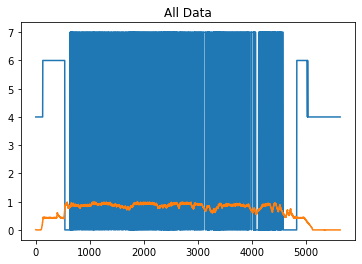

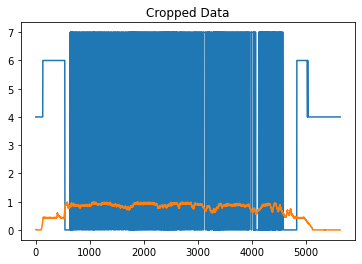

In [123]:
#Auto-Cropping
#The best way to determine when the drive stops/starts is to look for when the control code changes the first time and the last time
#This crop will then be applied to the rest of the data set and available in the cropped_data object

plt.figure(1)
plt.plot(data["status"][1:])
plt.plot(normalized_data["rpm"][1:])    
plt.title("All Data")
    

if auto_crop:
    plt.plot(data["status"][1:]) #First, remove the first point as it gives an errant reading

    first_status = data["status"][1]

    for i, status in enumerate(data["status"][1:]):
        if status != first_status:
            if i >= leading_indeces:
                crop_start = i-leading_indeces
            else:
                crop_start = i
            break

    last_status = data["status"][-1]

    reversed_status = data["status"][::-1]
    for i, status in enumerate(reversed_status):
        if status != last_status:
            if i >= leading_indeces:
                crop_end = i-leading_indeces
            else:
                crop_end = i
            break

    print("Auto-crop indexes:", crop_start, crop_end)
    plt.figure()
    #plt.plot(data["status"][crop_start:crop_end])
    
elif manual_crop:
    crop_start, crop_end = manual_crop
    
    
else: #No crop selected
    crop_start = 0
    crop_end = -1
    
plt.figure(2)
plt.plot(data["status"][crop_start:crop_end])
plt.plot(normalized_data["rpm"][crop_start:crop_end])
plt.title("Cropped Data")

In [124]:
#add data member for time in seconds rather than milliseconds
data["time_s"] = data["s_time"]/1000

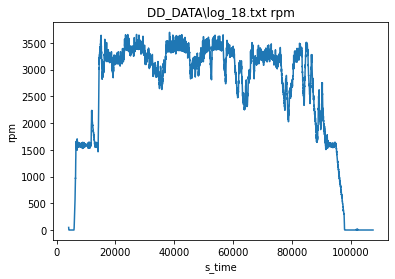

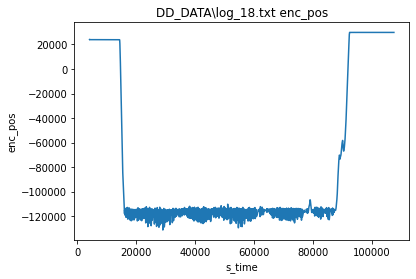

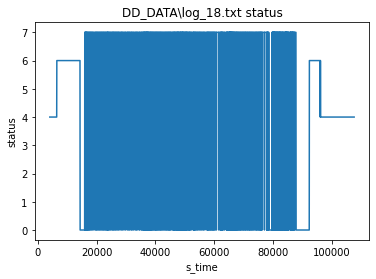

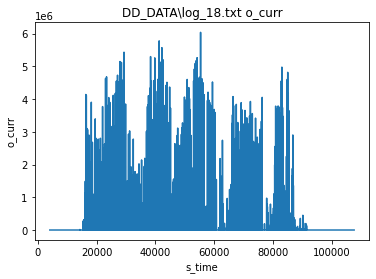

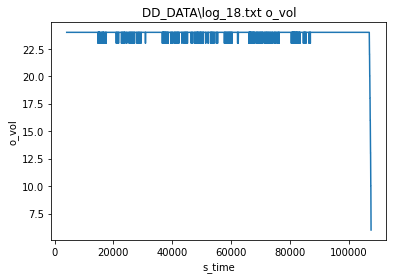

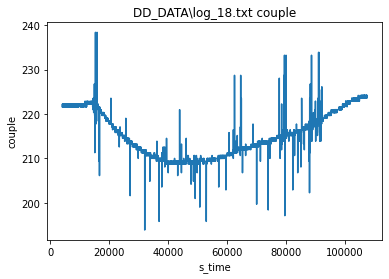

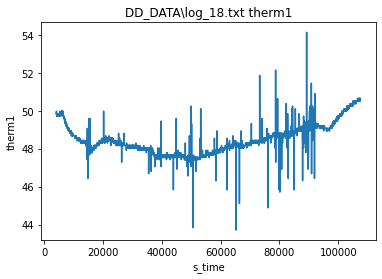

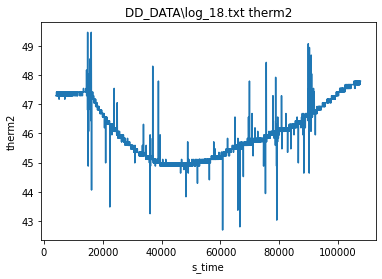

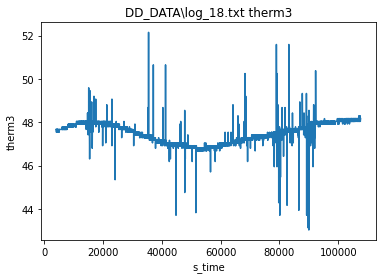

In [125]:
#Auto generate graphs using the auto-crop ranges and graphs given in auto_graphs
for x, y in auto_graphs:
    plt.figure()
    plt.plot(data[x][crop_start:crop_end], data[y][crop_start:crop_end])
    plt.ylabel(y)
    plt.xlabel(x)
    plt.title(file_path + " " + y)

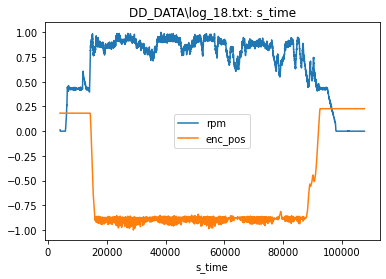

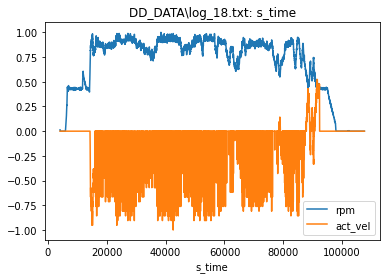

In [126]:
#Auto Generate Multiproperty graphs
for x, *args in multi_auto_graphs:
    plt.figure()
    plt.xlabel(x)
    for arg in args:
        plt.plot(normalized_data[x][crop_start:crop_end], normalized_data[arg][crop_start:crop_end], label = arg)
    plt.legend()
    plt.title(file_path + ": " + x)

# for x, y, z in multi_auto_graphs:
#     plt.figure()
#     plt.plot(data[x][crop_start:crop_end], normalized_data[y][crop_start:crop_end], label = y)
#     plt.plot(data[x][crop_start:crop_end], normalized_data[z][crop_start:crop_end], label = z)
#     plt.xlabel(x)
#     plt.title(file_path + " " + y + " & " + z)
#     plt.legend()
    
# plt.plot(data["time_s"][crop_start:crop_end], normalized_data["rpm"][crop_start:crop_end], label = "rpm")
# plt.plot(data["time_s"][crop_start:crop_end], normalized_data["enc_pos"][crop_start:crop_end], label = "encoder_pos")
# plt.title(file_path)
# plt.legend()

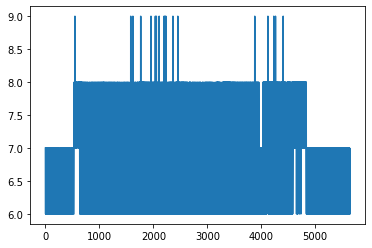

In [130]:
plt.plot(data["f_time"] - data["s_time"])

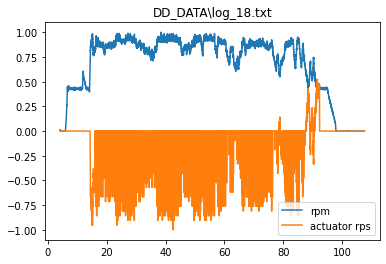

In [131]:
#rpm and actuator shift speed graph
plt.plot(data["time_s"][crop_start:crop_end], normalized_data["rpm"][crop_start:crop_end], label = "rpm")
plt.plot(data["time_s"][crop_start:crop_end], normalized_data["act_vel"][crop_start:crop_end], label = "actuator rps")
plt.title(file_path)
plt.legend()